# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

Let us obtain a dataframe with such characteristics. We may use `pivot_table`:

In [4]:
# Merging is not completely necessary at this point but it would work like this:
# df = pd.merge(df_offers, df_transactions)

matrix = df_transactions.pivot_table(index=['customer_name'], columns=['offer_id'], values='n').rename_axis(None, axis=1)

matrix = matrix.fillna(0).reset_index().rename(columns={'customer_name':'C_Name'})

matrix.head()

,C_Name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Alternatively, we may use the function `get_dummies`. This is somehow more convoluted in this case:

In [5]:
min_off = df_transactions["offer_id"].min()
max_off = df_transactions["offer_id"].max()

renaming = {'Oid_' + str(i) : i for i in range(min_off,max_off+1)}

matrix2 = df_transactions.drop(['n'], axis=1).rename(columns={'offer_id': 'Oid', 'customer_name': min_off-1})

matrix2 = pd.get_dummies(matrix2,columns=['Oid']).rename(columns=renaming)

matrix2 = matrix2.reindex(sorted(matrix2.columns), axis=1).rename(columns={min_off-1:'C_Name'})

matrix2 = matrix2.groupby(['C_Name']).sum().reset_index()

matrix2[list(range(min_off,max_off+1))] = matrix2[list(range(min_off,max_off+1))].astype(float)

matrix2.head()

,C_Name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Nevertheless, both results are identical:

In [6]:
matrix.equals(matrix2)

True

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In clustering we are interested in minimizing the distance between data points and the centroids of clusterings. This translates into minimizing $SS$.

In [7]:
x_cols = matrix.columns[1:]

In [8]:
from sklearn.cluster import KMeans

Ks = list(range(2,11))
inertias = []

for k in Ks:
    model = KMeans(n_clusters=k, random_state=10)
    model.fit(matrix[x_cols])
    inertias.append(model.inertia_)

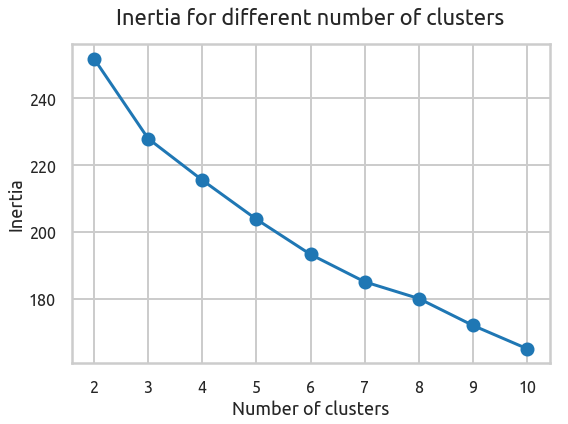

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(Ks,inertias)
ax.plot(Ks,inertias)
ax.set_ylabel('Inertia', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax.set_title("Inertia for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

$K = 5$ seems like a good option. Let us see how many members are in each cluster:

In [10]:
model = KMeans(n_clusters=5, random_state=10)
matrix2['model'] = model.fit_predict(matrix[x_cols])
memb_count = matrix2['model'].value_counts()

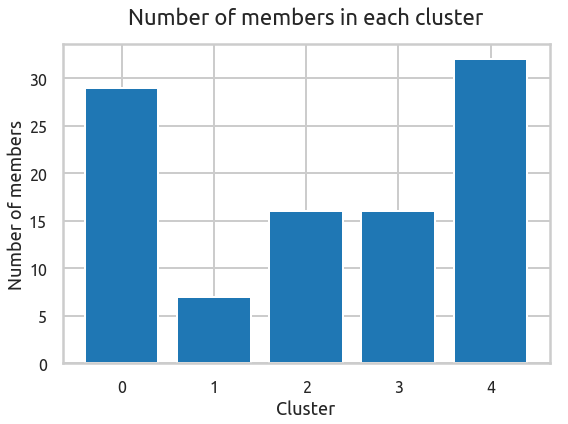

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(memb_count.reset_index()['index'],memb_count.reset_index()['model'])
ax.set_ylabel('Number of members', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Number of members in each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

Since the elbow choice comes from a 'thumb' rule, it is hard to precisely and consistently define the right number of clusters using it. In this particular case, and depending on the run, $K=6$ seemed also as a good choice.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>

</div>

For n_clusters = 2 The average silhouette_score is : 0.09365573283492713
For n_clusters = 3 The average silhouette_score is : 0.11889942863638556
For n_clusters = 4 The average silhouette_score is : 0.12347053919571699
For n_clusters = 5 The average silhouette_score is : 0.14092516241984757
For n_clusters = 6 The average silhouette_score is : 0.1371798939109807
For n_clusters = 7 The average silhouette_score is : 0.1161092456616906
For n_clusters = 8 The average silhouette_score is : 0.11339573832632867
For n_clusters = 9 The average silhouette_score is : 0.12505960527779877
For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


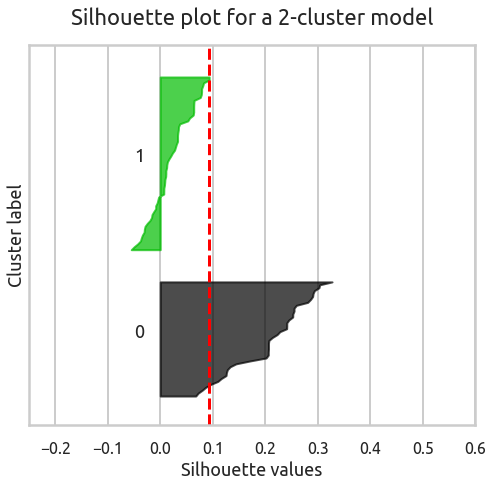

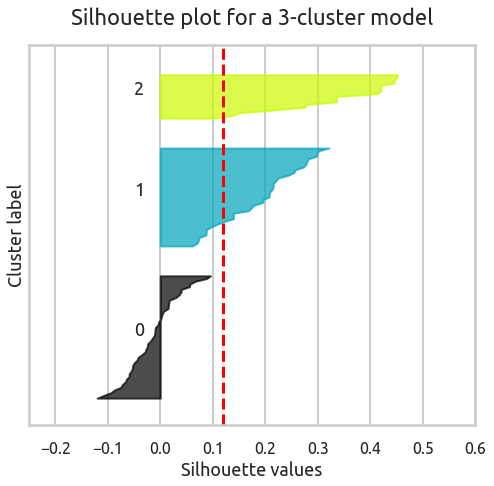

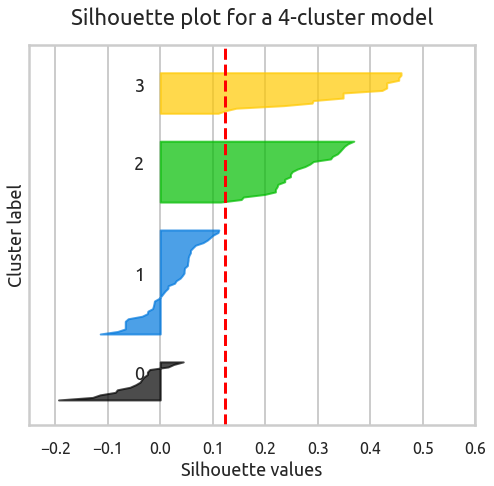

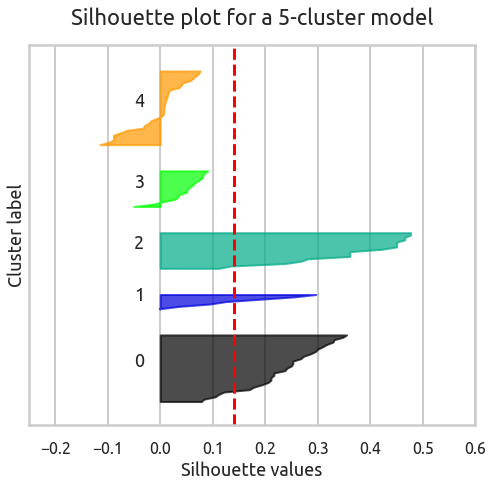

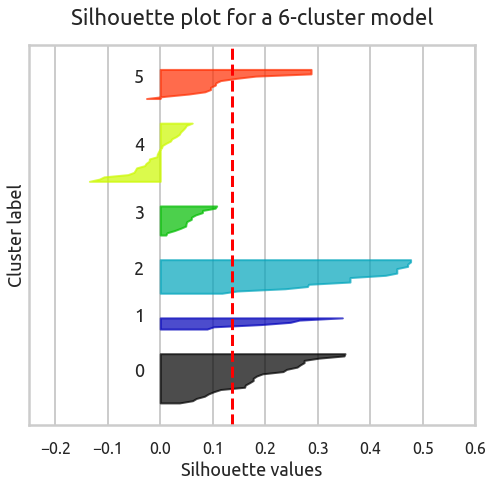

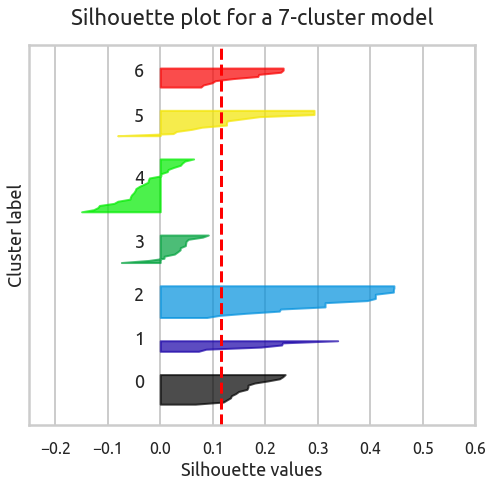

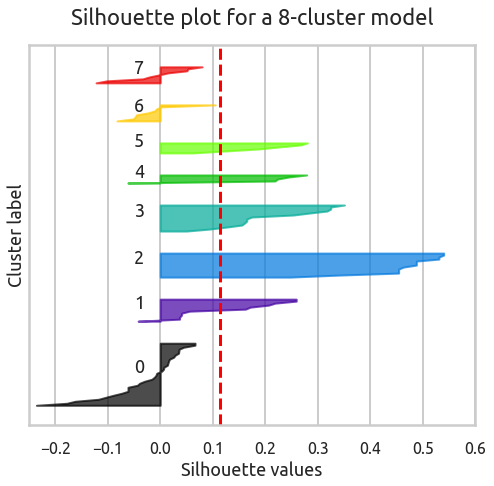

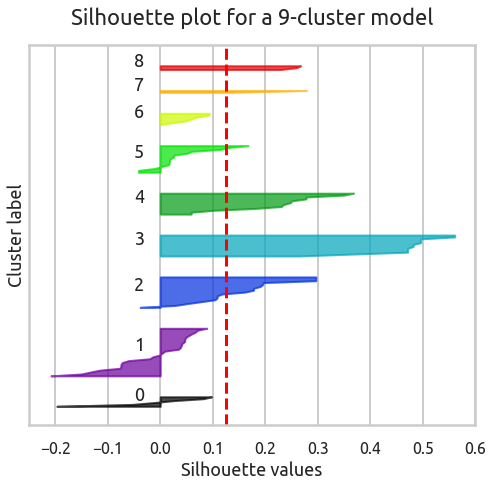

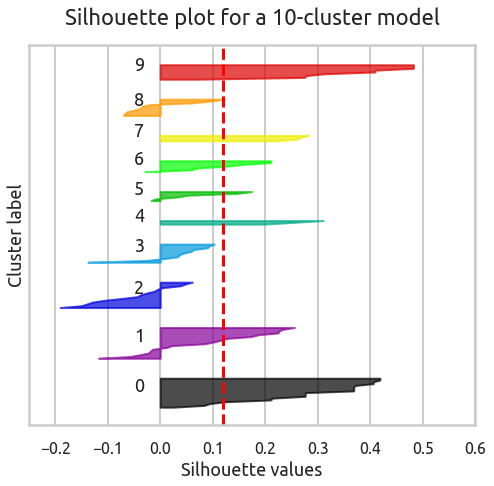

In [12]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

silhouettes = []

for k in Ks:

    fig, ax = plt.subplots(figsize=(8,7))

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.25, 0.65]
    ax.set_xlim([-0.25, 0.6])
    # The (k+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(matrix[x_cols]) + (k + 1) * 10])

    # Initialize the clusterer with k value and a random generator
    # seed of 10 for reproducibility.
    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(matrix[x_cols])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix[x_cols], model_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix[x_cols], model_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18, fontname='Ubuntu')

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot for a "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax.set_xlabel("Silhouette values", fontsize=18, fontname='Ubuntu')
    ax.set_ylabel("Cluster label", fontsize=18, fontname='Ubuntu')

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / tick
    #ax.set_xticks(list(np.linspace(-0.25, 0.65, num=7)))
    ax.tick_params(labelsize=16)
    plt.xticks(fontname='Ubuntu')

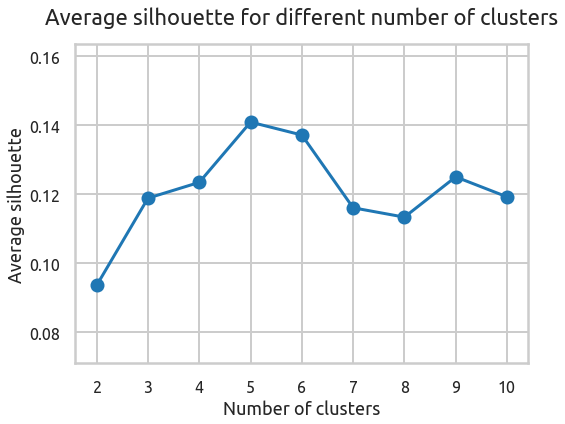

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(Ks,silhouettes)
ax.plot(Ks,silhouettes)
ax.set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax.set_title("Average silhouette for different number of clusters", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

$K = 5$ seems like the best option according to the average silhouette, which actually agrees with our elbow rule choice.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(matrix[x_cols])

transformed = pca.transform(matrix[x_cols])

matrix2['pca_x'] = transformed[:,0]

matrix2['pca_y'] = transformed[:,1]

customer_clusters = matrix2[['C_Name', 'model', 'pca_x', 'pca_y']].rename(columns={'C_Name':'customer_name'})

customer_clusters.head()

,customer_name,model,pca_x,pca_y
0,Adams,0,1.007580,0.108215
1,Allen,4,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


Let us visualize the cluster decompositions with the PCA projection:

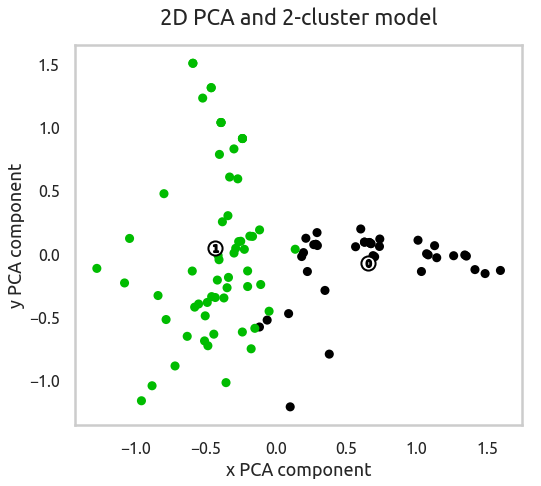

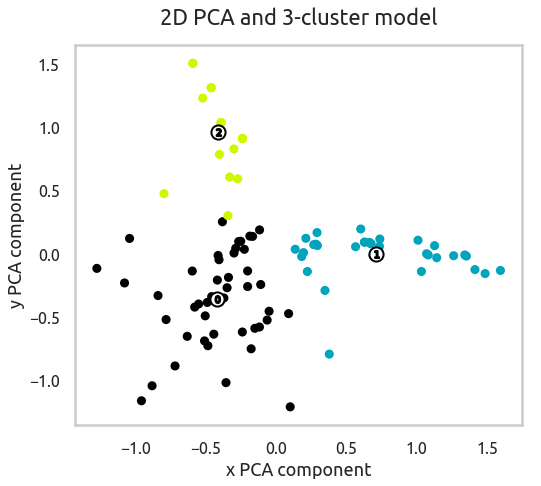

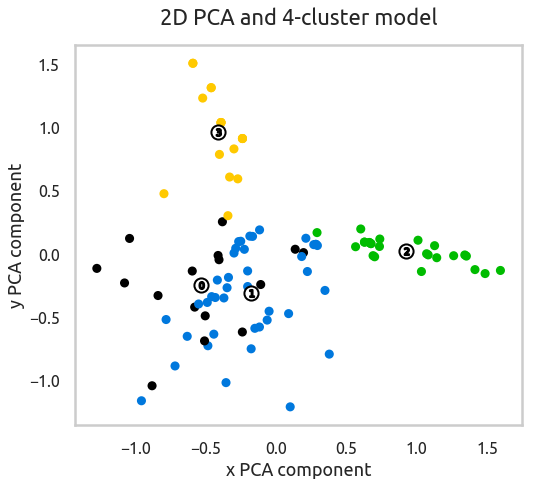

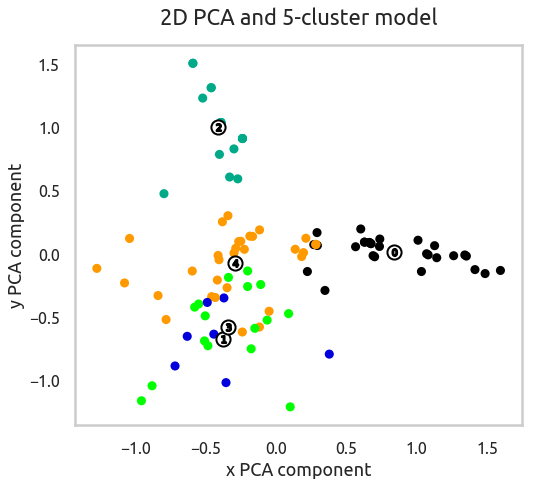

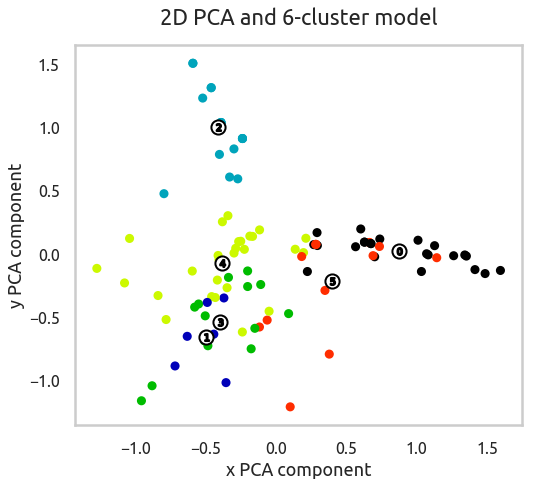

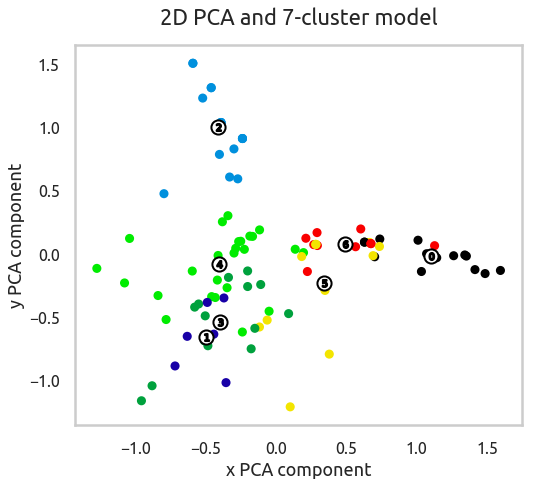

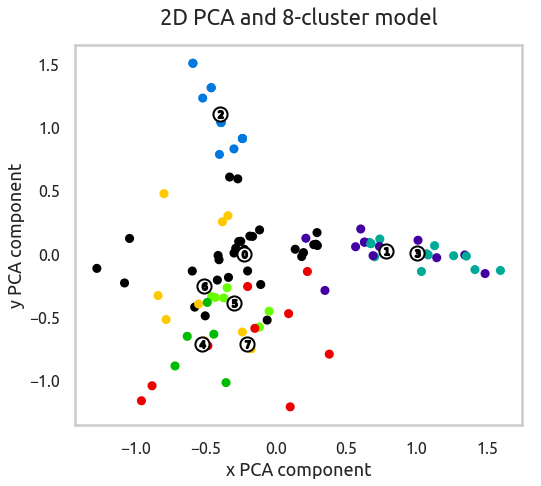

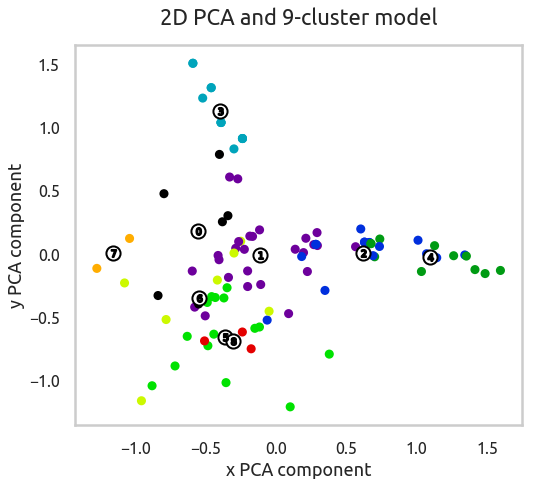

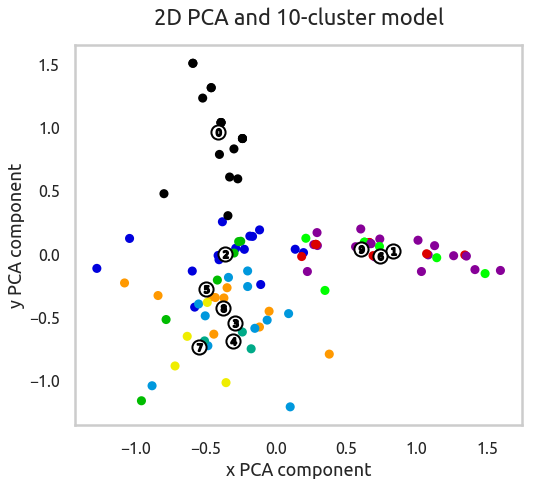

In [15]:
# sns.set_style("ticks")

for k in Ks:

    fig, ax = plt.subplots(figsize=(8,7))

    model = KMeans(n_clusters=k, random_state=10)
    model_labels = model.fit_predict(matrix[x_cols])
    
    colors = cm.nipy_spectral(model_labels.astype(float) / k)
    ax.scatter(transformed[:,0],transformed[:,1],c=colors,alpha=1, s=50)

    ax.set_title("2D PCA and "+str(k)+"-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
    ax.set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
    ax.set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
    # Labeling the clusters
    centers = model.cluster_centers_
    
    #Compute the PCA components of the cluster centers
    pca_transf_K_centers = pca.transform(centers)
    
    # Draw white circles at cluster centers
    ax.scatter(pca_transf_K_centers[:, 0], pca_transf_K_centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(pca_transf_K_centers):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax.tick_params(labelsize=16)
    ax.grid(False)
    plt.xticks(fontname='Ubuntu')
    plt.yticks(fontname='Ubuntu')

$K = 3$ looks like a particularly good choice in the proyected PCA subspace. Any bigger $K$ seems to show some level of intersection between the clusters. Visually, this seems like a more impactful method to define $K$ but one can always resort to a more quantitative approach to determine $K$ in a more objective way.

Now we may use a merged data frame to identify properties in the cluster decomposition:

In [16]:
df = pd.merge(df_transactions,customer_clusters)
df = pd.merge(df_offers, df)

Now let us make some graphic exploratory analysis:

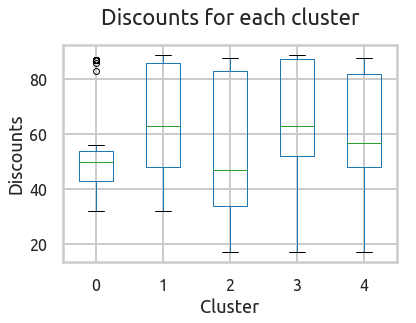

In [17]:
ax = df.pivot(columns='model', values='discount').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Discounts', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Discounts for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

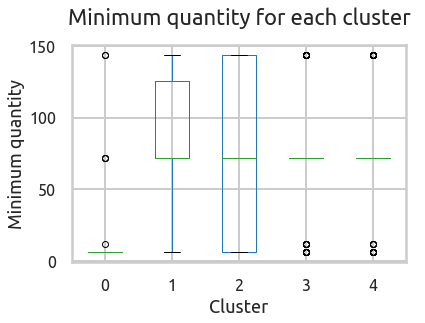

In [18]:
ax = df.pivot(columns='model', values='min_qty').rename_axis(None, axis=1).plot.box(grid=True)
ax.set_ylabel('Minimum quantity', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Minimum quantity for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

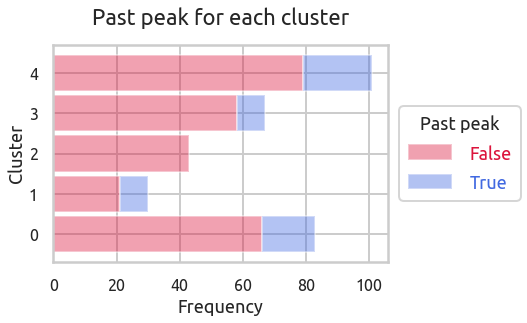

In [19]:
ax = pd.crosstab(df.model, df.past_peak).plot.barh(stacked=True,color=['crimson','royalblue'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['False','True'], title="Past peak", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Past peak for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

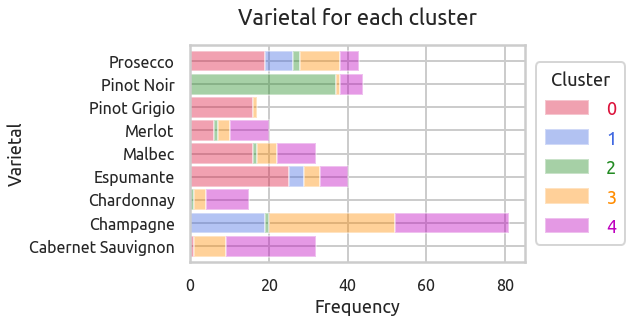

In [20]:
ax = pd.crosstab(df.varietal,df.model).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange', 'm'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3','4'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Varietal', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Varietal for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

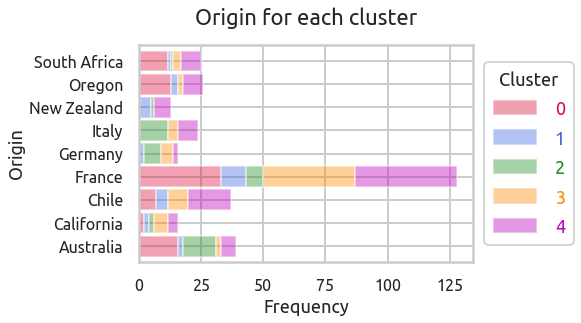

In [21]:
ax = pd.crosstab(df.origin,df.model).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange', 'm'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3','4'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')

ax.set_ylabel('Origin', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')


ax.set_title("Origin for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

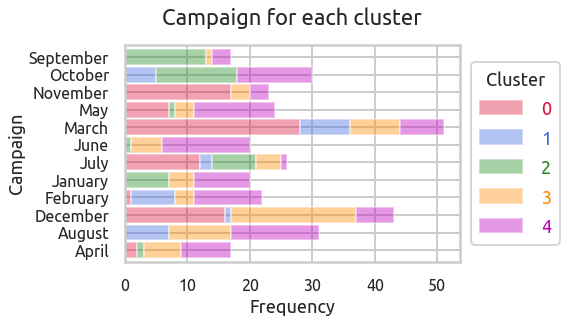

In [22]:
ax = pd.crosstab(df.campaign,df.model).plot.barh(stacked=True,color=['crimson','royalblue', 'forestgreen', 'darkorange', 'm'], alpha=0.4, width=0.9)

legend = ax.legend(labels=['0','1','2','3','4'], title="Cluster", loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.setp(ax.get_legend().get_texts()[0], fontsize='18', fontname='Ubuntu', color = 'crimson')
plt.setp(ax.get_legend().get_texts()[1], fontsize='18', fontname='Ubuntu', color = 'royalblue')
plt.setp(ax.get_legend().get_texts()[2], fontsize='18', fontname='Ubuntu', color = 'forestgreen')
plt.setp(ax.get_legend().get_texts()[3], fontsize='18', fontname='Ubuntu', color = 'darkorange')
plt.setp(ax.get_legend().get_texts()[4], fontsize='18', fontname='Ubuntu', color = 'm')
plt.setp(legend.get_title(),fontsize=18, fontname='Ubuntu')


ax.set_ylabel('Campaign', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Frequency', fontsize=18, fontname='Ubuntu')

ax.set_title("Campaign for each cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

Now we have explored some features shared for each cluster. By looking at the minimum quantity, we see that cluster 0 is characterized by having the minimum median. In the past peak feature, cluster 2 is all false. In terms of varietal, cluster 2 has a clear preference for Pinot Noir, Pinot Grigio is avoided by allmost all clusters but cluster 0, and cluster 1 has a preference for Champagne. In terms of origin, France seems the preferred one by almost all clusters, although cluster 2 seems to have a preference for Italy, Germany and Australia as well. Clusters 0 and 4 are also relatively well spread over other origins. Monthly distribution in the campaign feature is relatively spread for all clusters, although some slight trends might be there.

We can also 'revert' the PCA process to obtain a reduced version of the original data as expanded from their PCA components:

In [23]:
sigmas = np.std(matrix[x_cols], axis=0)
sigmas_diag = np.diag(sigmas)

mu = np.mean(matrix[x_cols], axis=0).values

X_hat_0 = np.matmul(pca.transform(matrix[x_cols]),pca.components_)
X_hat = np.matmul(X_hat_0,sigmas_diag) + mu

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

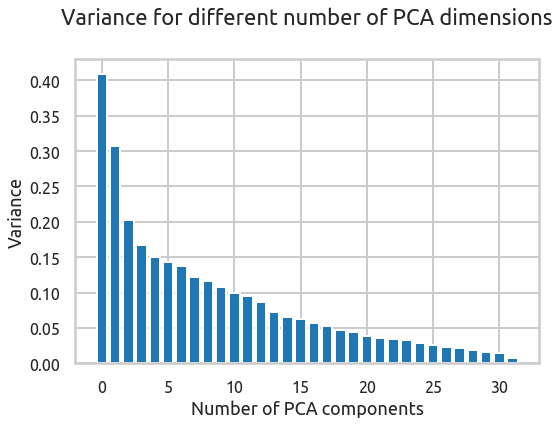

In [24]:
pca = PCA()
pca.fit(matrix[x_cols])
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(features, pca.explained_variance_)
ax.set_ylabel('Variance', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Number of PCA components', fontsize=18, fontname='Ubuntu')
ax.set_title("Variance for different number of PCA dimensions", fontsize=22, fontname='Ubuntu', pad= 35)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

Visually, the elbow rule would seem to suggest either 3 or 4 PCA dimensions to describe these data.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Let us start with `AffinityPropagation`:

In [25]:
from sklearn.cluster import AffinityPropagation

# Compute Affinity Propagation
af = AffinityPropagation().fit(matrix[x_cols])
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % silhouette_score(matrix[x_cols], labels))

Estimated number of clusters: 14
Silhouette Coefficient: 0.123


We find 14 clusters and a lower value for the silhouette coefficient than the one we found with $K=5$ in `KMeans`. Let us see how are the members distributed:

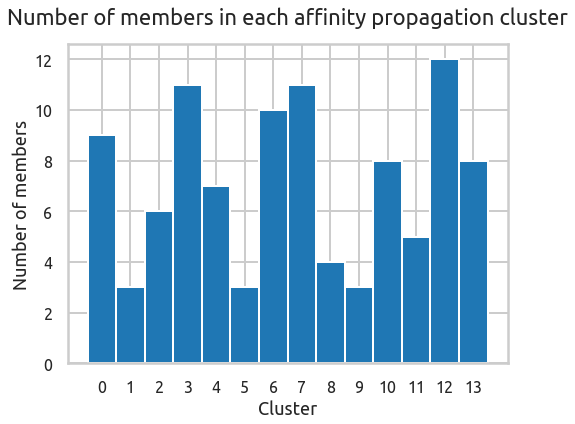

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
plt.hist(labels,bins=np.arange(15)-0.5)
ax.set_xticks(np.array(range(14)))
ax.set_ylabel('Number of members', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Cluster', fontsize=18, fontname='Ubuntu')
ax.set_title("Number of members in each affinity propagation cluster", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

Now we can consider `SpectralClustering`. Let us explore the same possible number of clusters and estimate silhouette coeficcients:

In [27]:
from sklearn.cluster import SpectralClustering

silhouettes = []

for k in Ks:
    model = SpectralClustering(n_clusters=k,random_state=10,assign_labels="discretize")
    #model = SpectralClustering(n_clusters=k,random_state=10,assign_labels="kmeans")
    model_labels = model.fit_predict(matrix[x_cols])
    silhouette_avg = silhouette_score(matrix[x_cols], model_labels)
    silhouettes.append(silhouette_avg)

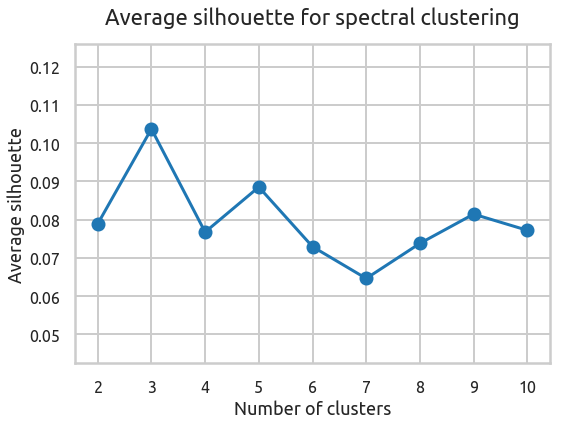

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(Ks,silhouettes)
ax.plot(Ks,silhouettes)
ax.set_ylabel('Average silhouette', fontsize=18, fontname='Ubuntu')
ax.set_xlabel('Number of clusters', fontsize=18, fontname='Ubuntu')
ax.set_title("Average silhouette for spectral clustering", fontsize=22, fontname='Ubuntu', pad= 20)
ax.tick_params(labelsize=16)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')

fig.tight_layout()

Average silhouettes are still relatively small. Let us visualize their 2D pca projection for the best case, $K=3$:

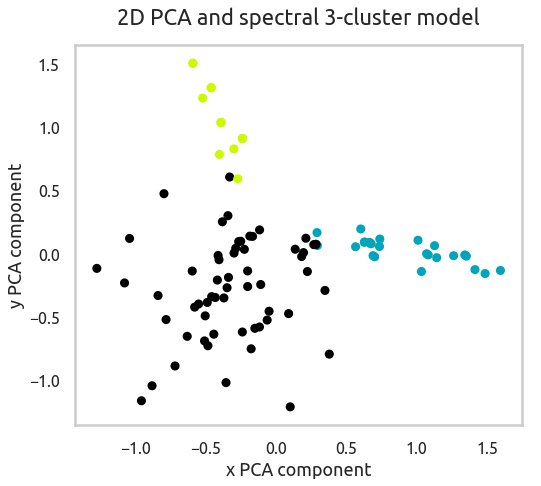

In [29]:
model = SpectralClustering(n_clusters=3,random_state=10,assign_labels="discretize")
#model = SpectralClustering(n_clusters=3,random_state=10,assign_labels="kmeans")
model_labels = model.fit_predict(matrix[x_cols])

fig, ax = plt.subplots(figsize=(8,7))
colors = cm.nipy_spectral(model_labels.astype(float) / 3)
ax.scatter(transformed[:,0],transformed[:,1],c=colors,alpha=1, s=50)

ax.set_title("2D PCA and spectral 3-cluster model", fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

This seems to show more overlap between clusters than the case of `KMeans` with equal number of clusters.

Let us jump to `AgglomerativeClustering`. We may compute the duration of the fitting and the average silhouettes for different types of `linkage`:

In [30]:
from sklearn.cluster import AgglomerativeClustering
#from time import time

#for linkage in ('ward', 'average', 'complete', 'single'):
for linkage in ('ward', 'average', 'complete'):
    for k in Ks:
        model = AgglomerativeClustering(linkage=linkage, n_clusters=k)
        #t0 = time()
        model.fit(matrix[x_cols])
        #print("Time used in %s linkage:\t%.2fs" % (linkage, time() - t0))
        model_labels = model.fit_predict(matrix[x_cols])
        silhouette_avg = silhouette_score(matrix[x_cols], model_labels)
        print("Silhouette coefficient with %i kernels and %s linkage: %0.3f" % (k, linkage,silhouette_avg))

Silhouette coefficient with 2 kernels and ward linkage: 0.083
Silhouette coefficient with 3 kernels and ward linkage: 0.116
Silhouette coefficient with 4 kernels and ward linkage: 0.129
Silhouette coefficient with 5 kernels and ward linkage: 0.141
Silhouette coefficient with 6 kernels and ward linkage: 0.147
Silhouette coefficient with 7 kernels and ward linkage: 0.153
Silhouette coefficient with 8 kernels and ward linkage: 0.156
Silhouette coefficient with 9 kernels and ward linkage: 0.121
Silhouette coefficient with 10 kernels and ward linkage: 0.098
Silhouette coefficient with 2 kernels and average linkage: 0.214
Silhouette coefficient with 3 kernels and average linkage: 0.190
Silhouette coefficient with 4 kernels and average linkage: 0.161
Silhouette coefficient with 5 kernels and average linkage: 0.154
Silhouette coefficient with 6 kernels and average linkage: 0.130
Silhouette coefficient with 7 kernels and average linkage: 0.119
Silhouette coefficient with 8 kernels and average l

In the case of an average `linkage`, silhouette decreases with the number of clusters, while the opposite seems to be the case for a ward `linkage`. A complete `linkage` seems to produce a less straightforward behavior. Let us take a look of these linkages for the case $K=3$:

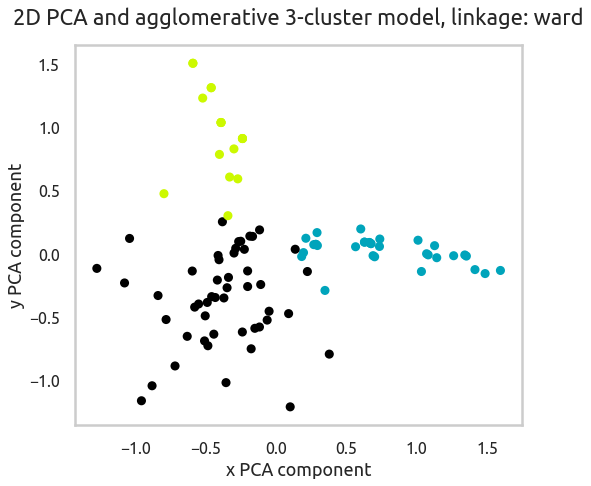

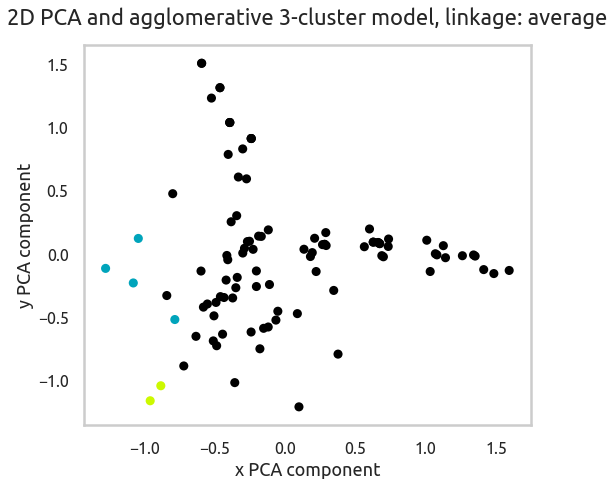

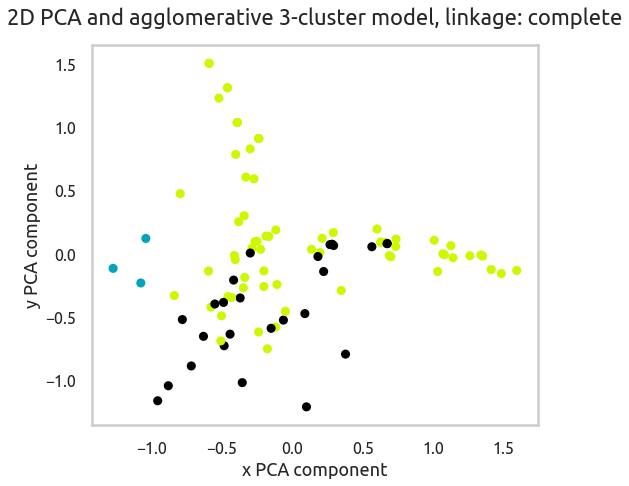

In [31]:
for linkage in ('ward', 'average', 'complete'):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=3)
    model_labels = model.fit_predict(matrix[x_cols])

    fig, ax = plt.subplots(figsize=(8,7))
    colors = cm.nipy_spectral(model_labels.astype(float) / 3)
    ax.scatter(transformed[:,0],transformed[:,1],c=colors,alpha=1, s=50)

    ax.set_title("2D PCA and agglomerative 3-cluster model, linkage: " + linkage, fontsize=22, fontname='Ubuntu', pad= 20)
    ax.set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
    ax.set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
    ax.tick_params(labelsize=16)
    ax.grid(False)
    plt.xticks(fontname='Ubuntu')
    plt.yticks(fontname='Ubuntu')

An average `linkage` actually produces a high silhouette, the highest in the $K=3$ subspace. Nevertheless, the clusters are very uneven, with one cluster absorving most of the users. This does not seem like a good fit for our costumer. On the other hand, ward linkages seem to produce similar results to those of `KMeans` with relatively large silhouettes. It might be the best overall if we base our analysis solely on silhouette scores and proportional size of clusters.

Let us move to `DBSCAN`. Here we shall take a look of the behavior in terms of the parameters `eps` and `min_samples`:

In [32]:
from sklearn.cluster import DBSCAN

Mss = [2,3,4,5,6]
Eps = [1,1.5]

for ms in Mss:
    for eps in Eps:
        model = DBSCAN(eps=eps,min_samples=ms)
        model_labels = model.fit_predict(matrix[x_cols])
        n_clusters = len(set(model_labels)) - (1 if -1 in model_labels else 0)
        silhouette_avg = silhouette_score(matrix[x_cols], model_labels)
        if n_clusters > 1:
            print('min_samples = '+str(ms)+', eps = '+str(eps)+', n_clusters = '+ str(n_clusters) +', silhouette coefficient = '+str(silhouette_avg))

min_samples = 2, eps = 1, n_clusters = 6, silhouette coefficient = 0.025452229723455587
min_samples = 2, eps = 1.5, n_clusters = 3, silhouette coefficient = 0.09500391877093202
min_samples = 3, eps = 1, n_clusters = 4, silhouette coefficient = 0.03831616142184094
min_samples = 4, eps = 1, n_clusters = 3, silhouette coefficient = 0.041771182765493825
min_samples = 5, eps = 1, n_clusters = 4, silhouette coefficient = 0.012715203274911742
min_samples = 6, eps = 1, n_clusters = 5, silhouette coefficient = 0.020528683190337592


Silhouettes in the best scenarions we explored are fairly small. Let us take a look of the PCA projections of the best case, `eps = 1.5` and `min_samples = 3`: 

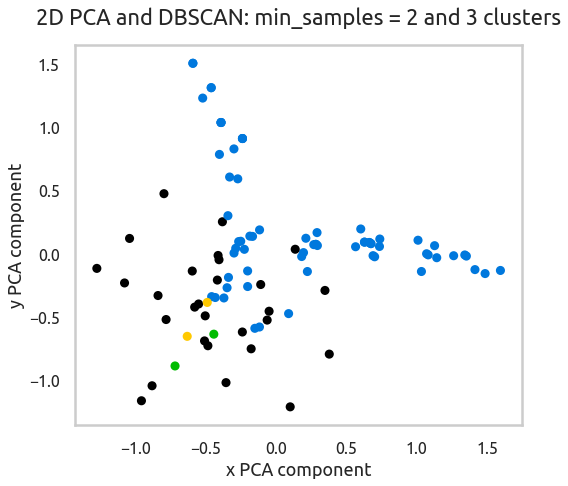

In [33]:
model = DBSCAN(eps=1.5,min_samples=2)
model_labels = model.fit_predict(matrix[x_cols])
n_clusters = len(set(model_labels)) - (1 if -1 in model_labels else 0)

fig, ax = plt.subplots(figsize=(8,7))
colors = cm.nipy_spectral((model_labels.astype(float)+1) / len(np.unique(model_labels)))
ax.scatter(transformed[:,0],transformed[:,1],c=colors,alpha=1, s=50)

ax.set_title("2D PCA and DBSCAN: min_samples = " +str(2)+' and '+str(n_clusters)+' clusters', fontsize=22, fontname='Ubuntu', pad= 20)
ax.set_xlabel("x PCA component", fontsize=18, fontname='Ubuntu')
ax.set_ylabel("y PCA component", fontsize=18, fontname='Ubuntu')
    
ax.tick_params(labelsize=16)
ax.grid(False)
plt.xticks(fontname='Ubuntu')
plt.yticks(fontname='Ubuntu')
plt.show()

 A lot of points have been regarded as noise! This is certainly not ideal.
 
Given these explorations and the observation we have made, we may conclude that either `KMeans` or `AgglomerativeClustering` with a ward `linkage` seem to be the best options for the clustering of this particular dataset.